In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import filtfilt, butter, argrelextrema
import numpy as np
%matplotlib inline 

In [17]:
# Файл с данными
csv_name = "Gleb ice 19 03 20_ensor_2020-03-19T11.16.30.288_FC7005861603_"
date = 190320
# Устанавливаем время старта пдля синхронизации с камерой
strt_dt = 6478

# Устанавливаем время клика синхронизации камеры
click_t = 7700

## Измерения Акселерометра

          x      y      z       sum
s                                  
7706 -0.045  0.006  1.026  1.027004
7709 -0.045  0.006  1.026  1.027004
7714 -0.046  0.007  1.024  1.025057
7720 -0.050  0.009  1.026  1.027257
7725 -0.051  0.010  1.024  1.025318


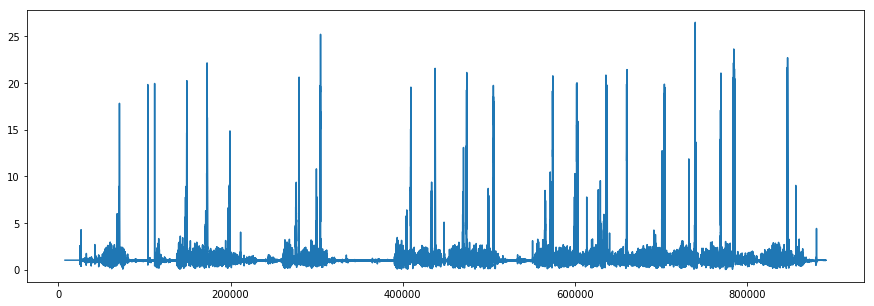

In [18]:
data_a = pd.read_csv(f"{csv_name}Accelerometer.csv")
data_a.columns = ['ms','t','s','x','y','z']
data_a = data_a.drop(['ms','t'], axis=1)

data_a['s']= (data_a['s']*1000-strt_dt).apply(int)
data_a = data_a.groupby('s').min()

data_a = data_a.loc[click_t:]
data_a['sum'] = (data_a['x']**2 + data_a['y']**2 + data_a['z']**2)**0.5

print(data_a.head(5))
plt.figure(figsize=(15,5))
plt.plot(data_a['sum'])

## Измерения Гироскопа

          x      y      z       sum
s                                  
7701  0.854 -0.183  0.366  0.946975
7705  0.610 -0.366  0.488  0.862670
7711  0.366 -0.488  0.488  0.781181
7715  0.244 -0.244  0.366  0.503019
7721 -0.122 -0.244  0.610  0.668222


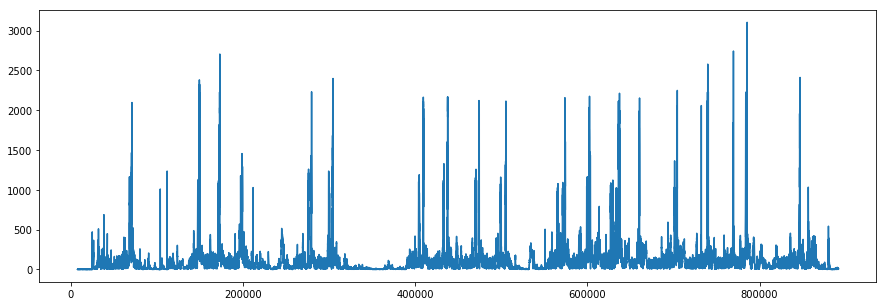

In [80]:
data_g = pd.read_csv(f"{csv_name}Gyroscope.csv")
data_g.columns = ['ms','t','s','x','y','z']
data_g = data_g.drop(['ms','t'], axis=1)

# Устанавливаем время старта пдля синхронизации с камерой
data_g['s']= (data_g['s']*1000-strt_dt).apply(int)
data_g = data_g.groupby('s').min()

# Устанавливаем время клика синхронизации камеры
data_g = data_g.loc[click_t:]
data_g['sum'] = (data_g['x']**2 + data_g['y']**2 + data_g['z']**2)**0.5

print(data_g.head(5))
plt.figure(figsize=(15,5))
plt.plot(data_g['sum'])

## Визуализация областей в которых по видео был зафиксирован прыжок

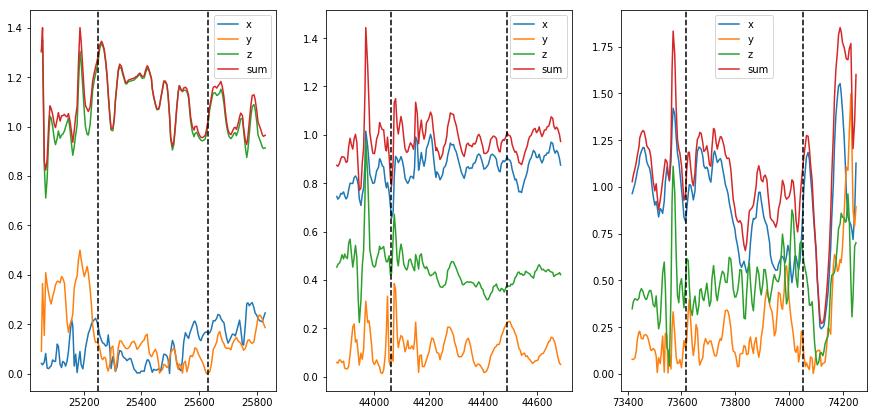

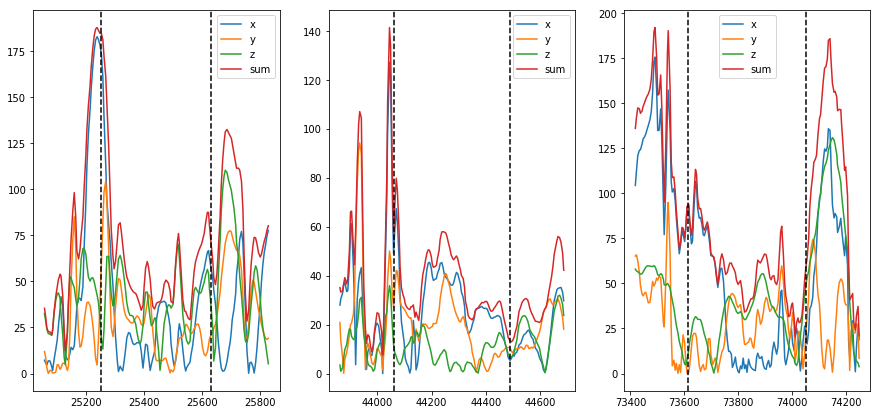

In [82]:
# Отсечки по прыжкам зафиксированные по камере
jmps_real = [(25250,25630),(44060,44490),(73615,74050),(85700,86187),
             (95568,96068),(146170,146470),(158160,158580),(182500,182940),
             (205100,205540),(234650,235110)]


# Количество прыжков для отображения (меньше размера jmps_real) 
num = 3
axis = ['x','y','z','sum']

def subploti(data):
    plt.figure(figsize=(15,7))
    for j, i in enumerate(jmps_real[:num]):
        a,b = i
        plt.subplot(1,num,j+1)
        # Все заданные измерения отображаются по модулю
        plt.plot(abs(data[axis]).loc[a-200:b+200])
        plt.axvline(a ,color='black', ls='--')
        plt.axvline(b ,color='black', ls='--')
        plt.legend(axis)

subploti(data_a)
subploti(data_g)

## Внесение результатов в БД

In [99]:
from mysql import connector 

In [100]:
# Задаем ID сессии (Вручную для удобства)
sid = 5
conn = connector.connect(host='127.0.0.1', user='root', password='T0_Gather', database='NAVKA2')
cursor = conn.cursor()

In [103]:
def inser_val(data, name = ""):
    cursor.execute(f"DELETE FROM {name} WHERE sid = {sid}")
    for i in data.iterrows():
        a = f"({sid}, {i[0]}, {i[1][0]}, {i[1][1]}, {i[1][2]})"
        cursor.execute(f"INSERT INTO {name} (sid,tick,x,y,z) VALUES {a}")
    conn.commit()

In [104]:
# Заносим измерения Акселерометра
inser_val(data_a, name = "vAcc")
inser_val(data_g, name = "vGyro")

## Проверка наличия данных в БД

In [105]:
cursor.execute(f"SELECT * FROM vGyro WHERE sid={sid}")
pd.DataFrame(cursor.fetchall()).head(5)

,0,1,2,3,4,5
0,130597,5,7701,0.854,-0.183,0.366
1,130598,5,7705,0.610,-0.366,0.488
2,130599,5,7711,0.366,-0.488,0.488
3,130600,5,7715,0.244,-0.244,0.366
4,130601,5,7721,-0.122,-0.244,0.610


In [106]:
cursor.execute(f"SELECT * FROM vAcc WHERE sid={sid}")
pd.DataFrame(cursor.fetchall()).head(5)

,0,1,2,3,4,5
0,901402,5,7706,-0.045,0.006,1.026
1,901403,5,7709,-0.045,0.006,1.026
2,901404,5,7714,-0.046,0.007,1.024
3,901405,5,7720,-0.050,0.009,1.026
4,901406,5,7725,-0.051,0.010,1.024
